Import libraries

In [20]:
import time
from datetime import datetime
from urllib.error import HTTPError
from urllib.error import URLError

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4

import requests
import json

import PyCO2SYS as pyco2

from erddapy import ERDDAP
from erddapy.doc_helpers import show_iframe
from erddapy import servers

import cartopy
cartopy.config['data_dir'] = './maps'
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as feat

# Set to display full length of rows
pd.set_option('max_colwidth',None)


# Retrieve data using ERDDAP
## What is ERDDAP?
From (https://coastwatch.pfeg.noaa.gov/erddap/information.html): *ERDDAP is a data server that gives you a simple, consistent way to download subsets of scientific datasets in common file formats and make graphs and maps.*
It allows to select and download a subset of data, removing the need to download unnecesarily large files. You can download the data in your preferred format, regardless of the format of origin. It standardizes the variable names and units of position (latitude, longitude, altitude/depth) and time; it is particularly useful for time variables.

erddapy is a python package that helps building the ERDDAP query URLs. For more information, the documentation can be found here: https://ioos.github.io/erddapy/

## Find datasets in ERDDAP
If you do not know any ERDDAP servers, you can search text search across 56 predefined instances here: http://erddap.com/. In addition, you can add servers you know of, or filter servers.

For a in-notebook solution, the cell below will retrieve a list of erddap servers and the datasets that have carbon variables, using their CF standard names. **Warning** it takes some time, approximately 15 minutes. The website is a lot quicker.

In [ ]:
stdnames=['surface_partial_pressure_of_carbon_dioxide_in_sea_water',
    'fugacity_of_carbon_dioxide_in_sea_water',
    'mole_concentration_of_dissolved_inorganic_carbon_in_sea_water',
    'moles_of_dissolved_inorganic_carbon_per_unit_mass_in_sea_water',
    'sea_water_ph_reported_on_total_scale',
    'sea_water_alkalinity_expressed_as_mole_equivalent']

starttime=time.time()

for s in servers:
    e=ERDDAP(s)
    for v in stdnames:
        kw= {"standard_name": v}
        search_url = e.get_search_url(response="csv", **kw)
        try:
            search=pd.read_csv(search_url)
        except HTTPError:
            pass
            print("No", stdname, "data in the server", s)
        except URLError:
            pass
            print(s,"throws an URL error")
        else:
            print(s,"has", {len(set(search["tabledap"].dropna()))},"tabledap datasets with",v)
            print(search[["Dataset ID","Title"]])
            if len(set(search["griddap"].dropna())) > 0:
                print(s,"has", {len(set(search["griddap"].dropna()))},"tabledap datasets with",v)

            

endtime=time.time()-starttime
print("\n Search took", endtime/60,"minutes")


## Standardization of column names

Create a dictionary in order to rename all columns the same, regardless of the data source

In [1]:
vardict ={'datevec':'DATEVECTOR','unixd':'UNIXDATE',
          'lat':'LATITUDE','lon':'LONGITUDE','dep':'DEPTH', 'pres':'PRESSURE',
          'temp':'TEMPERATURE', 'tempf':'TEMPERATURE_FLAG',
          'sal':'SALINITY','salf':'SALINITY_FLAG',
          'dic' : 'DIC', 'dicf':'DIC_FLAG', 'dicc':'DIC_CALCULATION',
          'alk': 'ALKALINITY', 'alkf':'ALKALINTY_FLAG', 'alkc':'ALKALINITY_CALCULATION',
          'ph': 'pH_TS','phf': 'pH_FLAG','phc': 'pH_CALCULATION',
          'fco2w':'FCO2_W','fco2wf':'FCO2W_FLAG'}

# pH data from two ERDDAP servers: EMODnet and IFREMER
For this exercise, we will search for pH data from two european sources: EMODnet and Ifremer. pH is the variable that is measured the most often, and has one of the longest time and space coverages of all the inorganic carbon variables.

## List datasets that contain pH in EMODnet
Get list of **datasets** that contain pH. We search by using the *standard_name* attribute and its Climate and Forecast (CF) name.

**e** (or **i** for the IFREMER server) is a python object with multiple methods. The ones we will use are:
* response: the format of the response. We will use .csv and read those to pandas dataframes, but many others are available (.nc, .json, .html, .mat, .tsv ...)
* get_* : returns a valid ERDDAP URL. **get_search_url** provides a list of datasets according the criteria established. **get_info_url** provides information about a particular dataset
* constraints: search and download constraints. Time, position, values of variables and/ or attributes
* dataset_id: to set which dataset we will explorte
* variables: set the variables to download if you do not wish to download the full dataset


In [17]:
e = ERDDAP(server="EMODNET", protocol='tabledap')
e.response= "csv"
search_url = e.get_search_url(**{
    "standard_name": "sea_water_ph_reported_on_total_scale"})
search = pd.read_csv(search_url)
display(search[["Title","Dataset ID"]])

,Title,Dataset ID
0,EMODnet Physics - Collection of (PHPH) TimeSeries Min/Max/Mean - MultiPointTimeSeriesObservation,EP_ERD_INT_PHPH_AL_TS_MINMAXMEAN
1,EMODnet Physics - Collection of Ph (PHPH) Profiles - MultiPointProfileObservation,EP_ERD_INT_PHPH_AL_PR_NRT
2,EMODnet Physics - Collection of Ph (PHPH) TimeSeries - MultiPointTimeSeriesObservation,EP_ERD_INT_PHPH_AL_TS_NRT


We are interested in all the pH measurements, not only their minimum/maximum values, which leaves the `MINMAXMEAN` dataset out. We will pick the profiles dataset first.
## Metadata
Before downloading the data itself, we will get some further information about the dataset **EP_ERD_INT_PHPH_AL_PR_NRT**:
* From the ID, we know that the data is NRT, so it will have gone through some, but not full QC (adjustments, calibrations, etc
* List the variables available in the dataset. We may be interested in all, or only some of them
* List the attributes of those variables


### List of variables available
When retrieving the dataset information using **get_info_url**, we get the full list of attributes, both global (`Variable Name NC_GLOBAL`) and per variable. In this case, that results in >200 lines. It provides also information about the type and the value of the attribute.

In [50]:
e.dataset_id="EP_ERD_INT_PHPH_AL_PR_NRT"
info = pd.read_csv(e.get_info_url())
display(info)

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,cdm_data_type,String,Profile
1,attribute,NC_GLOBAL,cdm_profile_variables,String,"time,EP_PLATFORM_ID"
2,attribute,NC_GLOBAL,citation,String,Data are the property of the producer/owner distributed through EMODnet Physics. EMODnet Physics and the partners are not responsible for improper use
3,attribute,NC_GLOBAL,comment,String,When missing DEPTH and PRES values are calculated on DEPTH or PRES variable data assuming 1 dbar = 1 m
4,attribute,NC_GLOBAL,contact,String,contacts@emodnet-physics.eu
...,...,...,...,...,...
196,variable,data_assembly_center,NaN,String,NaN
197,variable,institution_edmo_code,NaN,String,NaN
198,variable,institution_references,NaN,String,NaN
199,variable,institution,NaN,String,NaN


To get only the list of variable names, we can subset by `Row Type = variable`

In [13]:
print(", ".join(info.loc[info["Row Type"] == "variable", "Variable Name"]))

EP_PLATFORM_ID, EP_PLATFORM_TYPE, EP_PLATFORM_CODE, EP_PLATFORM_LINK, time, TIME_QC, depth, DEPTH_QC, pres, PRES_QC, latitude, longitude, POSITION_QC, DIRECTION, PHPH, PHPH_QC, PHPH_DM, site_code, platform_code, platform_name, pi_name, area, author, source, contributor_name, contributor_url, data_assembly_center, institution_edmo_code, institution_references, institution, wmo_platform_code


From the list we see the variable names as EMODnet stores them, information we need to retrieve their attributes. Let's check the time range available and the attributes for the variables `PHPH`and `PHPH_QC`

In [41]:
# Time coverage
print('Time coverage for pH is from', info.loc[info["Attribute Name"] == "time_coverage_start", "Value"].item(),
       'to' , info.loc[info["Attribute Name"] == "time_coverage_end", "Value"].item())
# pH attributes
print()
print('The attributes of the variable PHPH (pH) are')
display(info.loc[info["Variable Name"] == "PHPH", :])
print('The attributes of the variable PHPH (pH quality control flag) are')
display(info.loc[info["Variable Name"] == "PHPH_QC", :])

Time coverage for pH is from 1921-09-12T19:00:00Z to 2021-10-24T06:11:09Z

The attributes of the variable PHPH (pH) are


,Row Type,Variable Name,Attribute Name,Data Type,Value
166,variable,PHPH,NaN,float,NaN
167,attribute,PHPH,_FillValue,float,9.96921E36
168,attribute,PHPH,actual_range,float,"-31.728, 19297.486"
169,attribute,PHPH,ep_parameter_group,String,Water conductivity/ BioGeoChemical
170,attribute,PHPH,long_name,String,ph
171,attribute,PHPH,missing_value,float,9.96921E36
172,attribute,PHPH,SDN,String,SDN:P01::PHXXZZXX
173,attribute,PHPH,source_variable_name,String,PHPH
174,attribute,PHPH,standard_name,String,sea_water_ph_reported_on_total_scale
175,attribute,PHPH,units,String,1


The attributes of the variable PHPH (pH quality control flag) are


,Row Type,Variable Name,Attribute Name,Data Type,Value
176,variable,PHPH_QC,NaN,short,NaN
177,attribute,PHPH_QC,_FillValue,short,-32767
178,attribute,PHPH_QC,actual_range,short,"0, 9"
179,attribute,PHPH_QC,flag_meanings,String,no_qc_performed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed not_used nominal_value interpolated_value missing_value
180,attribute,PHPH_QC,long_name,String,ph quality flag
181,attribute,PHPH_QC,units,String,1


Information about the type of platform that recorded those datapoints is interesting, too, specially if we will compare with other sources of pH data. EMODnet has their own codes for platform type, stored in the variable `EP_PLATFORM_TYPE`. `platform_code` and `wmo_platform_code` can be of interest, too.

In [48]:
display(info.loc[info["Variable Name"] == "EP_PLATFORM_TYPE", :])

,Row Type,Variable Name,Attribute Name,Data Type,Value
67,variable,EP_PLATFORM_TYPE,NaN,String,NaN
68,attribute,EP_PLATFORM_TYPE,long_name,String,EMODnet Platform Type
69,attribute,EP_PLATFORM_TYPE,value_meanings,String,"CT: CTD, DB: Drifting Buoy, FB: FerryBox, GL: Glider, ML: Mini Logger, MM: Marine Mammals, MO: Mooring, TG: Tide Gauge"


We can now proceed to get the data, filtering by a particular time frame and pH data of quality "good_data" or "probably_good_data" (flags 1 and 2). Since the dataset is NRT, it is likely that many points have been flagged probably good out of caution, since they would not have been manually QCed and/or adjusted by a human, only been through automatic QC.

Position and time variables have a particular attribute: `axis`. For geolocated variables, latitude and longitude are usually `Y` and `X` axis, respectively. For ocean data `Z` variables can be depth and/or pressure.

In [59]:
display(info.loc[info["Attribute Name"] == "axis", ["Variable Name", "Value"]])
# To get them as list
varaxisname=e.get_var_by_attr(axis=lambda v: v in["X","Y","Z","T"])

,Variable Name,Value
77,time,T
97,depth,Z
115,pres,Z
131,latitude,Y
145,longitude,X


We now set the variables to be downloaded (geolocation, time and pH, and some platform metadata) and the constraints. Using the method `to_pandas` we can retrieve the data into a pandas dataframe. Other methods are `to_xarray` (particularly useful for gridded data) or `to_ncCF`.
We also rename the columns using the dictionary defined earlier, and print the size of the dataframe, to get an idea of the volume of data retrieved.

In [73]:
# Variables to download
e.variables=varaxisname + ['PHPH','PHPH_QC', 'EP_PLATFORM_TYPE', 'wmo_platform_code']

# Constraints
e.constraints= {
    "time>=": "2019-03-01T00:00:00Z",
    "time<=": "2019-03-15T23:59:59Z",
    "PHPH_QC>=": 1, # good data
    "PHPH_QC<=": 2} # probably good data

dtype=object
df_emodnet = e.to_pandas()

# Rename the columns to a common nomenclature using the dictionary vardict
df_emodnet.rename(
    columns={'latitude (degrees_north)': vardict['lat'], 'longitude (degrees_east)': vardict['lon'],
             'pres (dbar)': vardict['pres'], 'time (UTC)': vardict['datevec'],
             'temp_adjusted (degree_Celsius)': vardict['temp'], 'temp_adjusted_qc':vardict['tempf'],
             'PHPH (1)': vardict['ph'], 'ph_in_situ_total_qc': vardict['phf']},
        inplace=True)

# Print the variables retrieved
print("The EMODNet dataframe variables retrieved are", df_emodnet.columns.values)
# Size of the dataframe
print("The size of the EMODnet dataframe is", df_emodnet.shape[0],"rows (data points) and",df_emodnet.shape[1],"columns (variables)")

The EMODNet dataframe variables retrieved are ['LONGITUDE' 'depth (m)' 'PRESSURE' 'LATITUDE' 'DATEVECTOR' 'pH_TS'
 'PHPH_QC (1)' 'EP_PLATFORM_TYPE' 'wmo_platform_code']
The size of the EMODnet dataframe is 3095 rows (data points) and 9 columns (variables)


Let's dig a bit further in the platform metadata. The WMO platform code is a 5 or 7 digit code assigned to platforms that transmit in the Global Telecommunication System (GTS, for more information you can check here https://www.ocean-ops.org/dbcp/data/sharing.html). Ocean-OPS (https://www.ocean-ops.org/board) manages an extensive metadata catalogue of marine observation deployments, and it is possible to explore it through an API. 
Here we will determine how many different platforms with a WMO number are in the dataset, grouped by platform type, and which devices they are. 

In [89]:
# Want to check what type of platforms are available
print(df_emodnet.wmo_platform_code.groupby(df_emodnet.EP_PLATFORM_TYPE).unique())
import requests
import json
url = ("https://www.ocean-ops.org/api/preview/data/platform?exp=[%22wmos.wmo=%27"
    +str(5904468)+"%27%22]&include=[%22ref%22,%22wmos.wmo%22]}]&include=[%22ptfModel.name%22]")
rdata = requests.get(url)
jdata= json.loads(rdata.text)
print("The WMO platform code of",str(2) ,"corresponds to a", jdata['data'][0]['ptfModel']['name'], "device")


['PF']
EP_PLATFORM_TYPE
PF    [3901668, 3901669]
Name: wmo_platform_code, dtype: object
The WMO platform code of 2 corresponds to a APEX device


APEX is a type of Argo float

Similarly for IFREMER ERDDAP

In [10]:
i = ERDDAP(server="IFREMER", protocol='tabledap')
search_url = i.get_search_url(response="csv", **{
    "cf_standard_name": "sea_water_ph_reported_on_total_scale", # they use cf_standard
    "min_time": "2019-03-01",
    "max_time": "2019-03-15"})
search = pd.read_csv(search_url)
print(search[["Title","Dataset ID"]].values)

[['Argo Float Measurements' 'ArgoFloats']
 ['Argo float synthetic vertical profiles : BGC data'
  'ArgoFloats-synthetic-BGC']
 ['Global Ocean, In Situ Observation Copernicus (Copernicus Fishing Observing System)'
  'copernicus-fos']
 ['OceanGliders GDAC trajectories' 'OceanGlidersGDACTrajectories']
 ['SDC Baltic Sea Aggregation V2' 'SDC_BAL_AGG_V2']
 ['SDC Mediterranean Sea Aggregation V2' 'SDC_MED_AGG_V2']
 ['SDC North Atlantic Aggregation V2' 'SDC_NATL_AGG_V2']]


Pick the BGC-Argo synthetic profiles dataset

In [11]:
i.dataset_id="ArgoFloats-synthetic-BGC"
i.response="csv"

info = pd.read_csv(i.get_info_url())
# List dataset variables (very long!)

print(info.loc[(info["Attribute Name"] == "long_name") & 
                         (info["Variable Name"].str.contains('(?:^|_)ph(?:_|$)'))
                         , ["Variable Name", "Value"]])
print("\n")
# Time coverage
print(info.loc[info["Attribute Name"] == "time_coverage_start", "Value"])
print(info.loc[info["Attribute Name"] == "time_coverage_end", "Value"])
print("\n")
# pH attributes
print(i.get_var_by_attr(dataset_id="ArgoFloats-synthetic-BGC",cf_standard_name="sea_water_ph_reported_on_total_scale"))
print(info.loc[info["Variable Name"] == "ph_in_situ_total", :])
print("\n")
print(info.loc[info["Variable Name"] == "ph_in_situ_total_qc", :]) 
# QC is a string:

            Variable Name                                              Value
1042               vrs_ph  Voltage difference between reference and sourc...
1055              temp_ph                     Sea temperature from pH sensor
1068                ib_ph                          Base current of pH sensor
1081                vk_ph             Counter electrode voltage of pH sensor
1094                ik_ph             Counter electrode current of pH sensor
1108     ph_in_situ_total                                                 pH
1123      ph_in_situ_free                                                 pH
1136  ph_in_situ_seawater                                                 pH


34    2002-09-08T23:02:51Z
Name: Value, dtype: object
33    2021-10-26T13:00:13Z
Name: Value, dtype: object


['ph_in_situ_total']
       Row Type     Variable Name     Attribute Name Data Type  \
1104   variable  ph_in_situ_total                NaN     float   
1105  attribute  ph_in_situ_total         

In [12]:
i.get_var_by_attr(axis=lambda v: v in["X","Y","Z","T"])

['time', 'pres_adjusted', 'pres', 'latitude', 'longitude']

The dataset has 540 variables in total. Pick only the ones we're interested in..

In [43]:
# Reduce number of variables; total columns is 540
# Axes variables
varaxisname=i.get_var_by_attr(axis=lambda v: v in["X","Y","Z","T"])
varsnames=['ph_in_situ_total', 'ph_in_situ_total_qc']
i.variables=varaxisname + varsnames

i.constraints= {
    "time>=": "2019-03-01T00:00:00Z",
    "time<=": "2019-03-15T23:59:59Z",
    "ph_in_situ_total_qc=~": "(1|2)"} # good data and probably good data
        
dtype=object
df_ifremer = i.to_pandas()
print(df_ifremer.columns)
print(df_ifremer.shape)

Index(['time (UTC)', 'pres_adjusted (decibar)', 'pres (decibar)',
       'latitude (degrees_north)', 'longitude (degrees_east)',
       'ph_in_situ_total (dimensionless)', 'ph_in_situ_total_qc'],
      dtype='object')
(3090, 7)


In [44]:
df_ifremer.rename(
    columns={'latitude (degrees_north)': vardict['lat'], 'longitude (degrees_east)': vardict['lon'],
             'pres_adjusted (decibar)': vardict['pres'], 'time (UTC)': vardict['datevec'],
             'temp_adjusted (degree_Celsius)': vardict['temp'], 'temp_adjusted_qc':vardict['tempf'],
             'ph_in_situ_total (dimensionless)': vardict['ph'], 'ph_in_situ_total_qc': vardict['phf']},
        inplace=True)
df_ifremer['SOURCE']='BGC-Argo (IFREMER)'

In [76]:
dflist=[df_emodnet]
df=pd.concat(dflist)

dateforfile=datetime.now().strftime("%Y%m%d")
df.to_csv(dateforfile+'_pH_data_ERDDAP.csv')

Map scatterplot

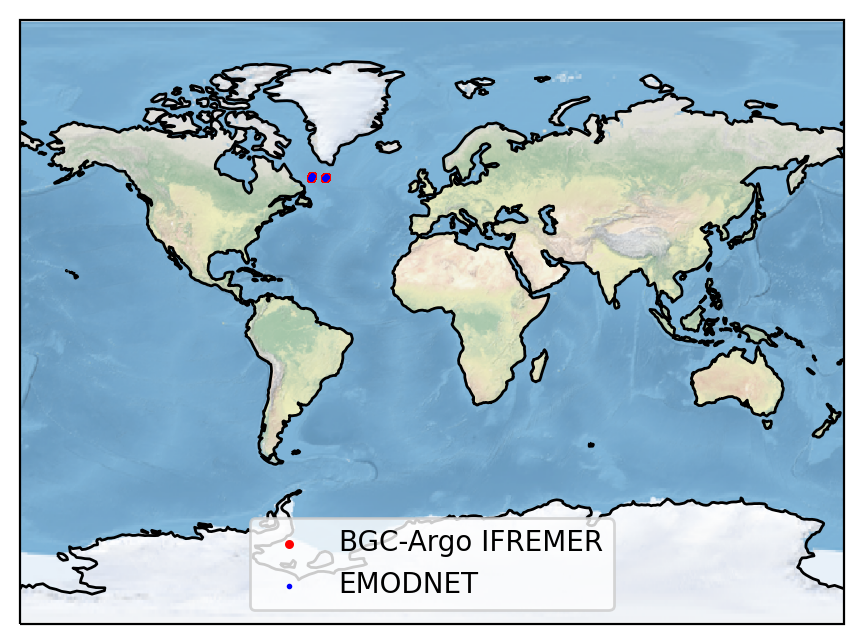

In [17]:
dflist=[df_ifremer,df_emodnet]
df=pd.concat(dflist)

proj=ccrs.cartopy.crs.Miller()
plt.figure(dpi=200)
ax = plt.axes(projection=proj)
#if ((df[vardict['lon']].min() < -175) & (df[vardict['lon']].max() > 175) & 
#    (df[vardict['lat']].min() <-85) & (df[vardict['lat']].max() > 85)) :
#    ax.set_extent([df[vardict['lon']].min()-5,df[vardict['lon']].max()+5, 
#                   df[vardict['lat']].max()+5,df[vardict['lat']].min()-5])
ax.stock_img()
ax.coastlines()

sc=ax.scatter(df_ifremer[vardict['lon']],df_ifremer[vardict['lat']],
    c='r',s=5,label='BGC-Argo IFREMER',
    transform=ccrs.PlateCarree())
sc=ax.scatter(df_emodnet[vardict['lon']],df_emodnet[vardict['lat']],
    c='b',s=1,label='EMODNET',
    transform=ccrs.PlateCarree())
    
#plt.colorbar(sc)
ax.legend(loc='lower center')
plt.show()

Latitude-depth scatterplots

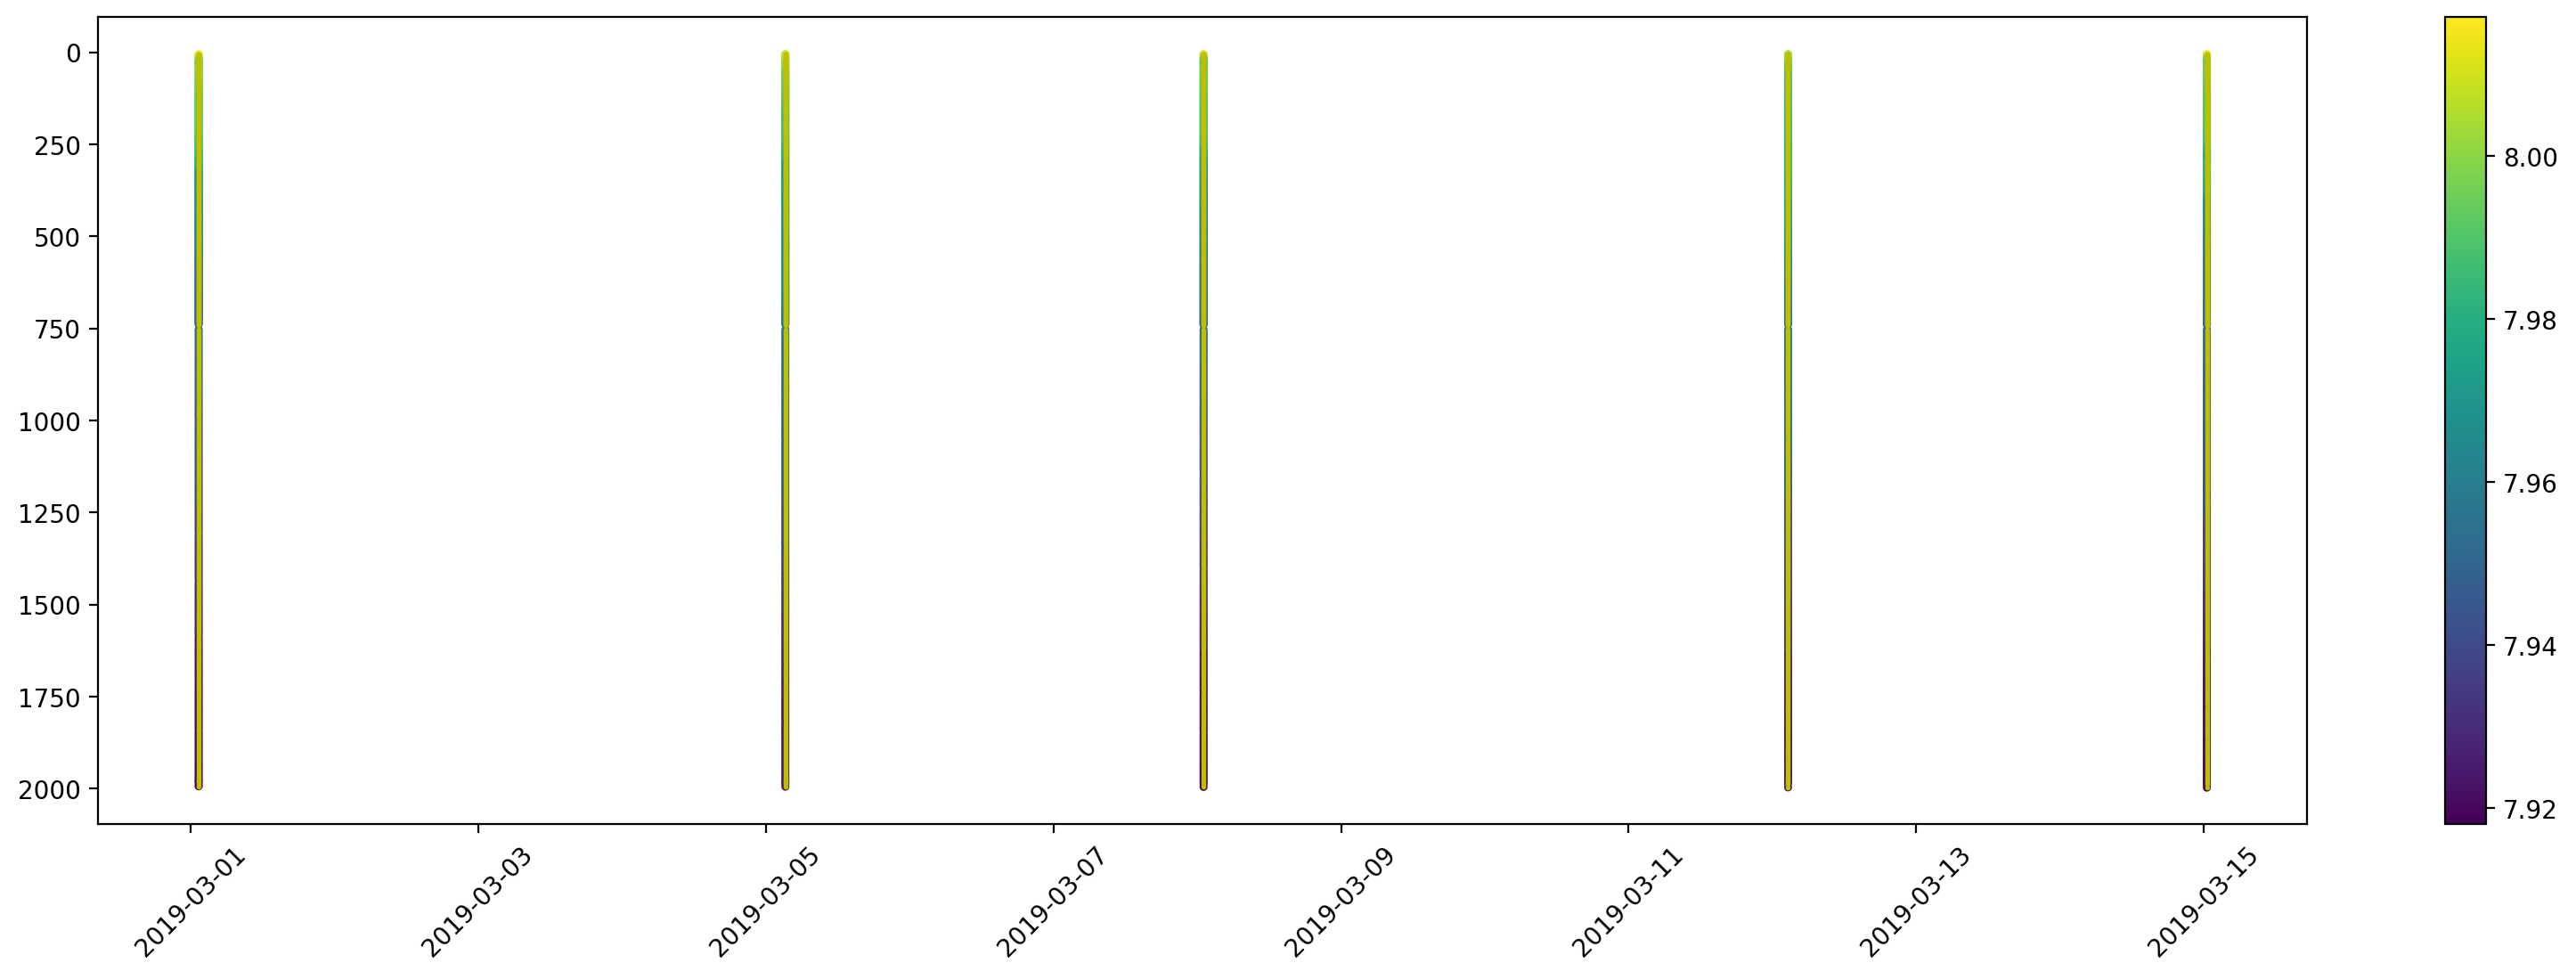

In [20]:
# latitude-depth scatterplots. Atlantic
# Mask Atlantic

plt.figure(figsize=(20,6), dpi=200)
ax = plt.axes()
sc=ax.scatter(pd.to_datetime(df_ifremer[vardict['datevec']]),
           df_ifremer[vardict['pres']],
           c=df_ifremer[vardict['ph']],
           s=5,label='BGC-Argo IFREMER')
ax.scatter(pd.to_datetime(df_emodnet[vardict['datevec']]),
           df_emodnet[vardict['pres']],
           c='y',
           s=1,label='EMODNET')
plt.xticks(rotation=45);
ax.invert_yaxis();
plt.colorbar(sc);
#ax.legend(loc='lower center')

Dates are exact, pH have rounding (3 decimal places in EMODNet, 6 in IFREMER), pressure is different (different adjustment in BGC?. In BGC, PRESS used is press_adjusted. EMODNet has pres dbar not-adjusted

(3095, 13) (3090, 8)
   PRESSURE  pH_TS
0      4.44  8.010
1      6.02  8.010
2      7.99  8.009
3     10.00  8.009
4     11.97  8.009
   PRESSURE     pH_TS
0      4.65  8.010144
1      6.23  8.009741
2      8.20  8.009403
3     10.21  8.008997
4     12.18  8.008775


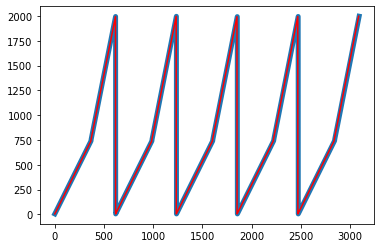

In [53]:
print(df_emodnet.shape, df_ifremer_comp.shape)
ax=plt.axes()
ax.plot(df_emodnet[vardict['pres']], linewidth=5)
ax.plot(df_ifremer_comp[vardict['pres']], c='r')
print(df_emodnet[[vardict['pres'],vardict['ph']]].iloc[0:5])
print(df_ifremer[[vardict['pres'],vardict['ph']]].iloc[0:5])

In [49]:
# Check duplicates
# Use pres (decibar) from ifremer to compare the data points
df_ifremer_comp=df_ifremer.copy()
df_ifremer_comp.rename(
    columns={'pres (decibar)': vardict['pres'], 
             vardict['pres']: 'pres_adjusted (decibar)'},
        inplace=True)
df_ifremer_comp=df_ifremer_comp.round({vardict['ph']: 3})
print(df_ifremer_comp[[vardict['pres'],vardict['ph']]].iloc[0:5])
print()
dataframes=[df_emodnet,df_ifremer_comp]


df=pd.concat(dataframes)
print(df.shape)
print(df.columns)
isdup=df.duplicated(subset=[vardict['lat'],vardict['lon'],vardict['datevec'],vardict['pres'],vardict['ph']], keep=False)
print(sum(isdup))

   PRESSURE  pH_TS
0      4.44  8.010
1      6.02  8.010
2      7.99  8.009
3     10.00  8.009
4     11.97  8.009

(6185, 16)
Index(['PRESSURE', 'LATITUDE', 'depth (m)', 'DATEVECTOR', 'LONGITUDE', 'pH_TS',
       'DEPTH_QC (1)', 'TIME_QC (1)', 'PRES_QC (1)', 'POSITION_QC (1)',
       'PHPH_QC (1)', 'platform_name', 'platform_code',
       'pres_adjusted (decibar)', 'pH_FLAG', 'SOURCE'],
      dtype='object')
6130


In [58]:
df.loc[~isdup]
#print(df_ifremer.iloc[168])
#print(df_emodnet.iloc[168])
print(df[~isdup].groupby('SOURCE').mean())

                     PRESSURE   LATITUDE  depth (m)  LONGITUDE    pH_TS  \
SOURCE                                                                    
BGC-Argo (IFREMER)  717.70376  56.286969        NaN -48.239728  7.96052   

                    DEPTH_QC (1)  TIME_QC (1)  PRES_QC (1)  POSITION_QC (1)  \
SOURCE                                                                        
BGC-Argo (IFREMER)           NaN          NaN          NaN              NaN   

                    PHPH_QC (1)  platform_code  pres_adjusted (decibar)  \
SOURCE                                                                    
BGC-Argo (IFREMER)          NaN            NaN               718.012165   

                    pH_FLAG  
SOURCE                       
BGC-Argo (IFREMER)      1.0  
